In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from scipy.interpolate import (InterpolatedUnivariateSpline as Spline1d,
                               RectBivariateSpline as Spline2d,
                               splmake, spleval, interp1d)

In [4]:
class SUGARSource(sncosmo.Source):
    """
    SUGAR source model
    """
    def __init__(self, sugar_modelDir='model_data'):
        self._modelDir  = sugar_modelDir
        self.name = 'SUGAR'
        self._parameters = np.array([1., 1., 1., 1., 1., 1.])
        self.param_names_latex = ['q1', 'q2', 'q3', 'Av', 'deltaM']
        self.version = 'v0.1'
        self.name = None
        self.model_data_filename = os.path.join(sugar_modelDir, 'SUGAR_model.asci')
        self.model_data = np.loadtxt(self.model_data_filename)
        self._numPhase = len(self._phase)
        self._numWave = len(self._wave)
        # M0, alpha1, alpha2, alpha3 = interpModel('model_data/', 'SUGAR_model.asci')
        self._M0Interp = self._splineIt(2)
        self._alpha1Interp = self._splineIt(3)
        self._alpha2Interp = self._splineIt(4)
        self._alpha3Interp = self._splineIt(5)
        cl = np.reshape(self.model_data[:, 6], (self._numWave, self._numPhase))
        self._colorlawInterp = interp1d(self._wave, cl[:, 0])
        
    def M0(self, phase, wave):
        return self._M0Interp(wave, phase)
    def alpha1(self, phase, wave):
        return self._alpha1Interp(wave, phase)
    def alpha2(self, phase, wave):
        return self._alpha2Interp(wave, phase)
    def alpha3 (self, phase, wave):
        return self._alpha3Interp(wave, phase)
    def color_law(self, wave):
        return self._colorlawInterp(wave)
    def _splineIt(self, columnNum):
        mval = self.model_data[:, columnNum]
        modelVal = np.reshape(mval, (self._numWave, self._numPhase))
        return Spline2d(self._wave, self._phase, modelVal, kx=1, ky=1)
    
    @property    
    def _wave(self):
        return np.unique(self.model_data[:, 1])
    
    @property    
    def _phase(self):
        return np.unique(self.model_data[:, 0])
    
    @property
    def _param_names(self):
        return ['q1', 'q2', 'q3', 'Av', 'DeltaM']
    
    # Required Functions
    def minwave(self):
        return self._wave[0]
    def maxwave(self):
        return self._wave[-1]
    def minphase(self):
        return self._phase[0]
    def maxphase (self):
        return self._phase[-1]
    
    def _flux(self, phase, wave):
        #print ('===========================================')
        phase = np.ravel(phase)
        wave = np.ravel(wave)
        #print "HOIOOISD OODSDOU ", len(phase) , len(wave)
        M0 = self.M0(phase, wave)
        common_shape = np.shape(M0)
        lenphase = common_shape[1]
        alpha1 = self.alpha1(phase, wave) 
        alpha2 = self.alpha2(phase, wave) 
        alpha3 = self.alpha3(phase, wave) 
        cl = np.reshape(np.repeat(self.color_law(wave), lenphase),common_shape)
        mags =  M0 + \
                self._parameters[0] * alpha1 +\
                self._parameters[1] * alpha2 +\
                self._parameters[2] * alpha3 +\
                self._parameters[3] * cl +\
                self._parameters[4] * np.ones(shape=(len(wave), len(phase)))
        
        
        #print(np.shape(mags))
        #print 'func', (np.shape(cl))
        return 10.0 ** ( -0.4 * mags.T)

In [5]:
#np.ravel([2, 3])

In [6]:
#len(np.ravel(2))

In [7]:
s = SUGARSource()

In [8]:
s.parameters

array([ 1.,  1.,  1.,  1.,  1.,  1.])

In [9]:
s.set(q1=3.)

In [10]:
s.parameters

array([ 3.,  1.,  1.,  1.,  1.,  1.])

In [11]:
testphase = [-4., 0., 4.]
testwave = np.arange(4000., 8000.)

In [12]:
np.shape(s.M0(phase=testphase, wave=testwave))

(4000, 3)

In [13]:
phaseflux = s.flux(phase=testphase, wave=testwave)

In [14]:
np.shape(phaseflux)

(3, 4000)

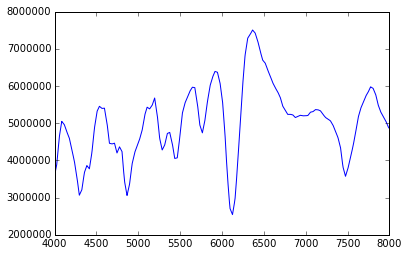

In [16]:
plt.plot(testwave, phaseflux[0])

How do single phases behave ?

In [17]:
phaseflux = s._flux(0., testwave)
print np.shape(phaseflux)

(1, 4000)


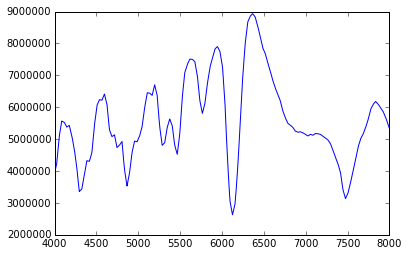

In [19]:
plt.plot(testwave, phaseflux[0])

In [20]:
s.flux([0.], testwave)

array([[ 3933217.23319028,  3945106.39383698,  3957031.49252945, ...,
         5357455.3470352 ,  5349252.60281765,  5341062.41773659]])

In [21]:
model = sncosmo.Model(source=s)

In [22]:
model.flux(time=[0.], wave=np.arange(5500., 8000., 100))

array([[ 5345573.02398652,  7427119.30106679,  7075015.57081363,
         6214086.10411811,  7677004.58528002,  7372149.4936951 ,
         2981189.15948314,  4684950.42877473,  8537345.68313023,
         8793524.94686297,  7784386.66477131,  6901224.14879651,
         6157076.26916095,  5471212.71476425,  5221729.05412764,
         5144967.86646268,  5149632.06105458,  5099150.14498367,
         4827091.52402498,  4092007.30181659,  3280459.89983431,
         4419851.38477714,  5256107.02792536,  6063389.49061405,
         5963174.70691585]])

(5272.5, 12877.5)


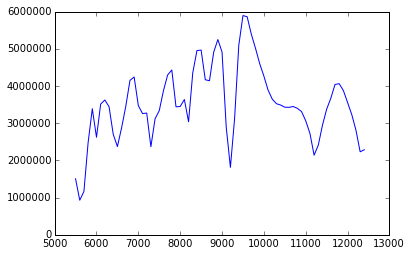

In [25]:
model = sncosmo.Model(source=s)
model.set(z=0.5)
print (model.minwave(), model.maxwave())
fig, ax = plt.subplots()
ax.plot ( np.arange(5500., 12500, 100), model.flux(time=[0.], wave=np.arange(5500., 12500., 100))[0])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

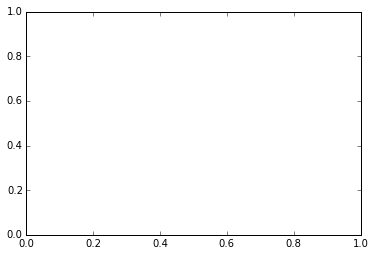

In [27]:
fig, ax = plt.subplots()
ax.plot(np.arange(-5., 10., 1.), 
        model.bandflux(time=np.arange(10.), band=['desr', 'desr','desr'], zp=25., zpsys='ab'),'ko')
#ax.plot(np.arange(-5., 10., 1.), 
#        model.bandflux(time=np.arange(-5., 10., 1.), band=['desi'], zp=25., zpsys='ab'),'rs')

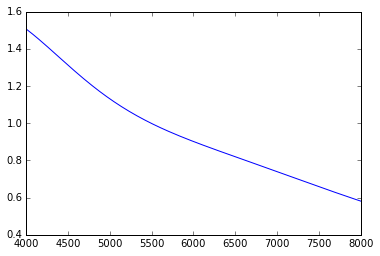

In [50]:
waves = np.arange(4000., 8000.)
plt.plot(waves, s.color_law(waves))

In [51]:
import pandas as pd

In [131]:
df = pd.DataFrame(d, columns=['phase', 'wave', 'M0', 'alpha1', 'alpha2', 'alpha3', 'colorlaw','deltaM'])

In [132]:
df.head()

,phase,wave,M0,alpha1,alpha2,alpha3,colorlaw,deltaM
0,-12,3515,-17.411158,0.074592,0.005779,0.050207,1.645699,1
1,-9,3515,-18.306160,0.090305,0.008847,0.044811,1.645699,1
2,-6,3515,-18.837455,0.103977,0.011244,0.040811,1.645699,1
3,-3,3515,-19.043419,0.115833,0.013019,0.038150,1.645699,1
4,0,3515,-18.985262,0.126170,0.014294,0.036696,1.645699,1


In [133]:
x = df.query('phase > -0.5 and phase < 0.5')

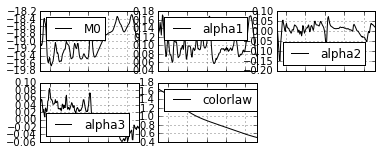

In [134]:
fig = x.plot(x='wave', y=['M0', 'alpha1', 'alpha2', 'alpha3', 'colorlaw'], 
       layout=(3,3), 
       subplots=True)

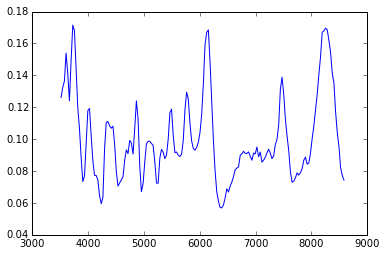

In [136]:
plt.plot(s._wave, s.alpha1(0., s._wave)[:, 0])

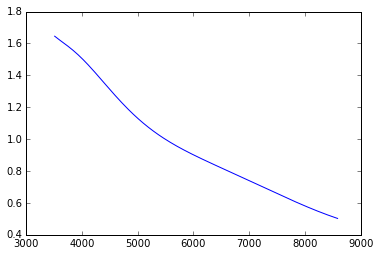

In [116]:
plt.plot(s._wave, s.color_law(s._wave))

In [115]:
np.shape(s.alpha1(0., s._wave))

(1, 170)

In [161]:
np.shape(np.ones(shape=(len(s._wave), len(s._phase))))

(170, 19)

In [ ]:
np.broadcast_arrays(np.ones)

In [179]:
np.asarray(3)

array(3)

In [180]:
np.ravel(3)

array([3])

In [181]:
help(np.ravel)

Help on function ravel in module numpy.core.fromnumeric:

ravel(a, order='C')
    Return a contiguous flattened array.
    
    A 1-D array, containing the elements of the input, is returned.  A copy is
    made only if needed.
    
    As of NumPy 1.10, the returned array will have the same type as the input
    array. (for example, a masked array will be returned for a masked array
    input)
    
    Parameters
    ----------
    a : array_like
        Input array.  The elements in `a` are read in the order specified by
        `order`, and packed as a 1-D array.
    order : {'C','F', 'A', 'K'}, optional
    
        The elements of `a` are read using this index order. 'C' means
        to index the elements in row-major, C-style order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest.  'F' means to index the elements
        in column-major, Fortran-style order, with the
        first index changing fastest, and the last index